In [ ]:
# default_exp nbeats.model

In [ ]:
# hide
import sys

sys.path.append("..")
import pandas as pd
%load_ext autoreload
%autoreload 2

/home/tako/dev/env37/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/home/tako/dev/env37/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


# N-Beats model

> A basic architecture for time series forecasting.


The approach is based on https://arxiv.org/abs/1905.10437


In [ ]:
# hide
from nbdev.showdoc import *
from fastcore.test import *

In [ ]:
#export
from fastcore.utils import *
from fastcore.imports import *
from fastai2.basics import *
from fastai2.callback.hook import num_features_model
from fastai2.callback.all import *
from fastai2.layers import *
from fastai2.torch_core import *
from torch.autograd import Variable
from fastseq.all import *

In [ ]:
# export
def linspace(lookback, horizon,device=None):
    device = ifnone(device, default_device())
    lin_space = torch.linspace(
        -lookback+1, horizon, lookback + horizon, requires_grad=False
    ).to(device)
    b_ls = Variable(lin_space[:lookback])
    f_ls = Variable(lin_space[lookback:])
    return b_ls, f_ls

In [ ]:
print(linspace(10, 5))

(tensor([-9., -8., -7., -6., -5., -4., -3., -2., -1.,  0.], device='cuda:0'), tensor([1., 2., 3., 4., 5.], device='cuda:0'))


In [ ]:
# hide
def _linspace(lookback, horizon,bias, device=None):
    device = ifnone(device, default_device())
    bias = torch.sigmoid(bias)*lookback - lookback/2
    print(bias.shape)
    lin_space = torch.linspace(
        -lookback+1, horizon, lookback + horizon, requires_grad=False
    ).to(device)
    lin_space = torch.ones_like(bias)*lin_space + bias
    b_ls = Variable(lin_space[:,:lookback])
    f_ls = Variable(lin_space[:,lookback:])
    return b_ls, f_ls

In [ ]:
# hide
b = torch.ones(64,1, device = default_device())*0
print(linspace(10, 5,b)[0].shape,_linspace(10, 5,b)[0].mean(0))
b = torch.ones(64,1, device = default_device())*100
print(linspace(10, 5,b)[0].shape,_linspace(10, 5,b)[0].mean(0))
b = torch.ones(64,1, device = default_device())*-100
print(linspace(10, 5,b)[0].shape,_linspace(10, 5,b)[0].mean(0))

torch.Size([64, 1])
torch.Size([10]) tensor([-9., -8., -7., -6., -5., -4., -3., -2., -1.,  0.], device='cuda:0')
torch.Size([64, 1])
torch.Size([10]) tensor([-4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.,  5.], device='cuda:0')
torch.Size([64, 1])
torch.Size([10]) tensor([-14., -13., -12., -11., -10.,  -9.,  -8.,  -7.,  -6.,  -5.],
       device='cuda:0')


In [ ]:
# hide
device = default_device()

In [ ]:
# export
def make_base(u_in, layers,use_bn,ps):    
    sizes = L(u_in) + layers
    ps = ifnone(ps, L([0]) * len(layers))        
    actns = [MishJit() for _ in range(len(sizes)-1)]
    _layers = [LinBnDrop(sizes[i], sizes[i+1], bn=use_bn, p=p, act=a)
                   for i,(p,a) in enumerate(zip(ps, actns))]
    return nn.Sequential(*_layers)

In [ ]:
# export
class Block(Module):
    def __init__(self, fnc_f, fnc_b=None, base=None, **kwargs):
        self.base = ifnone(base, make_base(self.lookback, self.layers, self.use_bn, self.ps))
        
        self.att = self.__dict__.get('att', None)
        if self.att:
            self.att = LinBnDrop(self.layers[-1], self.thetas_dim)
        if self.share_thetas:
            self.theta_fc = LinBnDrop(self.layers[-1], self.thetas_dim)
        else:
            self.theta_b_fc = LinBnDrop(self.layers[-1], self.thetas_dim)
            self.theta_f_fc = LinBnDrop(self.layers[-1], self.thetas_dim)
            print('not going to share thetas')
            
        self.fnc_f = fnc_f
        self.fnc_b = ifnone(fnc_b, fnc_f)
        self.to(self.device)
        self.y_range = getattr(self,'y_range', None)
        
        
    def forward(self, x):
        res = {}
        x = self.base(x)
        if self.share_thetas:
            theta_b = self.theta_fc(x)
            theta_f = self.theta_fc(x)
        else:
            theta_b = self.theta_b_fc(x)
            theta_f = self.theta_f_fc(x)
            
        if self.att:
            w = torch.sigmoid(self.att(x))
            theta_b, theta_f = theta_b * w, theta_b * w
            res['attention'] = w
            
        theta_b = self.apply_range(theta_b)
        theta_f = self.apply_range(theta_f) 
        b, f = linspace(self.lookback, self.horizon, device = self.device)
        backcast = self.fnc_b(theta_b, b)
        forecast = self.fnc_f(theta_f, f)
        res.update({'b':backcast,'f': forecast, 'theta': (theta_b + theta_f)})
        return res
    
    def apply_range(self, x):
        if self.y_range is None:
            return x
        r= (self.y_range[1]-self.y_range[0]) * torch.sigmoid(x) + self.y_range[0]
        return r * self.scale

In [ ]:
# export
class SeasonalityModel(object):   
    """Returns a function with `period` being the period of least frequent aproximations function. """
    def __init__(self, period=None):
        self.period = period
        
    def __call__(self, thetas, t):  
        p = thetas.size()[-1]
        assert p < 12, f"thetas_dim is too big. p = {p}"
        p1, p2 = (p // 2, p // 2) if p % 2 == 0 else (p // 2, p // 2 + 1)
        period = ifnone(self.period, ((t.max()-t.min()))*2)
        freq_scale = 1*2**-(torch.arange(float(p)))
        s1 = [torch.cos((np.pi/(.5* period * freq_scale[i] ))*t)[None,:] for i in range(p1)] # H/2-1
        s2 = [torch.sin((np.pi/(.5* period * freq_scale[i] ))*t)[None,:] for i in range(p2)]
        S = torch.cat([*s1, *s2])
        return thetas.mm(S)
    

In [ ]:
# export
class SeasonalityBlock(Block):
    def __init__(
        self, layers:L, thetas_dim:int, device, lookback=10, horizon=5, use_bn=True, season = None,
            bn_final=False, ps:L=None, share_thetas=True, y_range=[-1,1], att=True, scale_exp = 2, stand_alone=False, base = None,**kwargs
    ):       
        store_attr(self,"y_range,device,layers,thetas_dim,use_bn,ps,lookback,horizon,bn_final,share_thetas,att,stand_alone,base" ) 
        half_dim =self.thetas_dim//2 if self.thetas_dim%2 == 0 else self.thetas_dim//2+1
        s = 1*scale_exp**-(torch.arange(float(half_dim))).to(self.device)
        if self.thetas_dim %2 == 0:
            self.scale = torch.cat([s,s])
        else:
            self.scale = torch.cat([s,s[:-1]])
        season = ifnone(season, self.horizon)
        super().__init__(SeasonalityModel(season)) 
        self.to(device)
        
    def forward(self, x):
        if self.stand_alone:
            dct = super().forward(x[:,0,:])
            return torch.cat([dct['b'][:,None,:], dct['f'][:,None,:]],dim=-1)
        else:
            return super().forward(x)

In [ ]:
show_doc(SeasonalityModel, name='SeasonalityModel')

<h2 id="SeasonalityModel" class="doc_header"><code>class</code> <code>SeasonalityModel</code><a href="" class="source_link" style="float:right">[source]</a></h2>

> <code>SeasonalityModel</code>(**`period`**=*`None`*)

Returns a function with `period` being the period of least frequent aproximations function. 

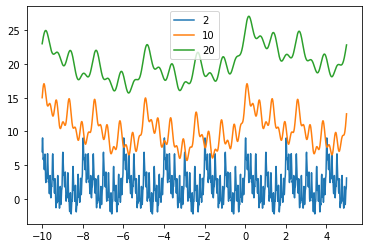

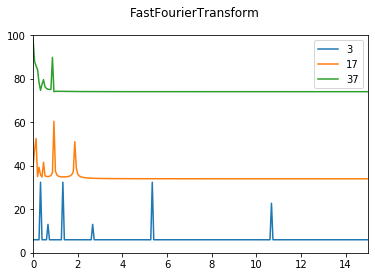

In [ ]:
start, end = -10, 5
theta = (torch.ones(11, device='cuda:0'))[None,:]
for period in [2,10,20]:
    fnc = SeasonalityModel(period)
    t = torch.arange(start, end, .01, device='cuda:0')
    plt.plot(t.cpu(),period+ fnc(theta, t).cpu().T, label=str(period))
plt.legend()

f = plt.figure()
# sample spacing
T = .01
for period in [3,17,37]:
    fnc = SeasonalityModel(period)
    t = torch.arange(start, end, T, device='cuda:0')
    N = int(len(t))
    res =fnc(theta, t)[:,:,None]
    res = torch.cat([res,torch.zeros_like(res)],-1)
    ft = torch.fft(res, 1, True)[:,:,0].cpu()
    plt.plot(np.linspace(0.0, 1.0/(2.0*T), int(N/2)),2*period+abs(ft[0,:N//2]) , label=str(period))
    plt.axis([0,15,0,100])
f.suptitle('FastFourierTransform')
plt.legend()

(1, 57)
Train:20; Valid: 10; Test 10


epoch,train_loss,valid_loss,time
0,1.510267,1.109039,00:00
1,1.215003,1.007382,00:00
2,1.196370,1.141669,00:00
3,1.159219,1.121578,00:00
4,1.127926,1.098952,00:00
5,1.089807,1.061384,00:00
6,1.063341,1.033222,00:00
7,1.031270,1.035182,00:00
8,1.003059,1.018976,00:00
9,0.990703,1.154488,00:00


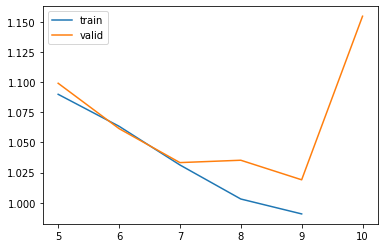

In [ ]:
horizon, lookback = 7,25
items = dummy_data_generator(50, 7, nrows=10, norm=True)
data = TSDataLoaders.from_items(items, horizon = horizon, lookback=lookback, step=5, after_batch = NormalizeTS(), valid_pct=.5)
                                
mdl = SeasonalityBlock([256,256], thetas_dim=6, device = data.train.device, horizon=horizon, lookback=lookback,stand_alone=True, season = lookback+horizon)
learn = Learner(data, mdl, loss_func=F.mse_loss, opt_func= Adam, )                             
                
learn.fit(10, .1)
learn.recorder.plot_loss()     

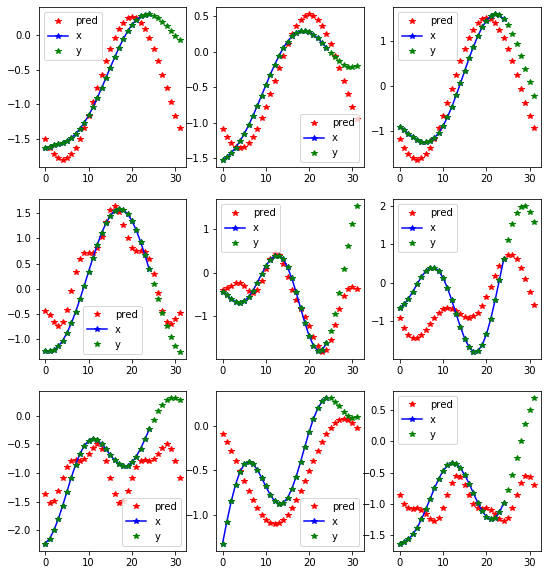

In [ ]:
learn.show_results(0)

In [ ]:
# hide
mdl = SeasonalityBlock([256], thetas_dim=3, device=device, lookback=100, horizon=10)
dct = mdl(torch.randn(64,100).to(device))
test_eq(dct['b'].shape, (64,100))
test_eq(dct['f'].shape, (64,10))
test_eq(dct['attention'].shape, (64,3))


mdl = SeasonalityBlock([256], thetas_dim=4, device=device, lookback=100, horizon=10, stand_alone=True)
bf = mdl(torch.randn(64,1,100).to(device))
test_eq(bf.shape, (64,1,110))

In [ ]:
# export
def trend_model(thetas, t):
    p = thetas.size()[-1]
    assert p <= 4, f"thetas_dim is too big. p={p}"
    a = [torch.pow(t, i)[None,:] for i in range(p)]
    T = torch.cat(a).float()
    return thetas.mm(T)

In [ ]:
# export
class TrendBlock(Block):
    def __init__(
        self, layers:L, device, thetas_dim, lookback=10, horizon=5, use_bn=True,
        bn_final=False, ps:L=None, share_thetas=True, y_range=[-.1, .1], att = True, scale_exp = 10,stand_alone=False,base=None,**kwargs
    ):        
        store_attr(self,"y_range,device,layers,thetas_dim,use_bn,ps,lookback,horizon,bn_final,share_thetas,att,stand_alone,base" ) 
        self.scale = 1*scale_exp**-(torch.arange(float(self.thetas_dim))).to(self.device)
        super().__init__(trend_model)        
        self.to(device)
        
    def forward(self, x):
        if self.stand_alone:
            dct = super().forward(x[:,0,:])
            return torch.cat([dct['b'][:,None,:], dct['f'][:,None,:]],dim=-1)
        else:
            return super().forward(x)

In [ ]:
show_doc(trend_model, name='trend_model')

<h4 id="trend_model" class="doc_header"><code>trend_model</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>trend_model</code>(**`thetas`**, **`t`**)



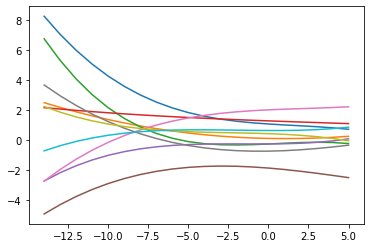

In [ ]:
t = tensor([-14., -13., -12., -11., -10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,
         -2.,  -1.,   0., 1,2,3,4,5], device='cuda:0')
dims = 4
for i in range(10):
    theta = (torch.randn(dims, device='cuda:0'))[None,:] *1*10**-(torch.arange(float(dims))).to(device='cuda:0')
    plt.plot(t.cpu(),trend_model(theta,t).cpu().T)

(1, 57)
Train:20; Valid: 10; Test 10


epoch,train_loss,valid_loss,time
0,1.068756,3.135297,00:00
1,5.062179,2.411083,00:00
2,4.025242,0.927974,00:00
3,4.824226,1.061213,00:00
4,4.085876,1.061213,00:00
5,3.593795,1.061213,00:00
6,3.229419,1.061213,00:00
7,2.962371,1.061213,00:00
8,2.754783,1.061213,00:00
9,2.588996,1.061213,00:00


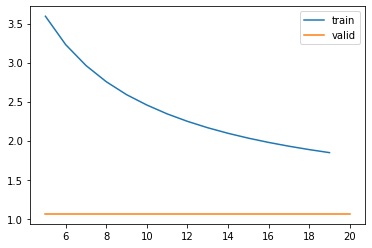

In [ ]:
horizon, lookback = 7,25
items = dummy_data_generator(50, 7, nrows=10, norm=True, signal_type='trend')
data = TSDataLoaders.from_items(items, horizon = horizon, lookback=lookback, step=5, after_batch = NormalizeTS(), valid_pct=.5)
                                
mdl = TrendBlock([256,256], thetas_dim=4, device = data.train.device, horizon=horizon, lookback=lookback, stand_alone=True, y_range=[-.5, .5])
learn = Learner(data, mdl, loss_func=F.mse_loss, opt_func= Adam, )                             
                
learn.fit(20, .1)
learn.recorder.plot_loss()

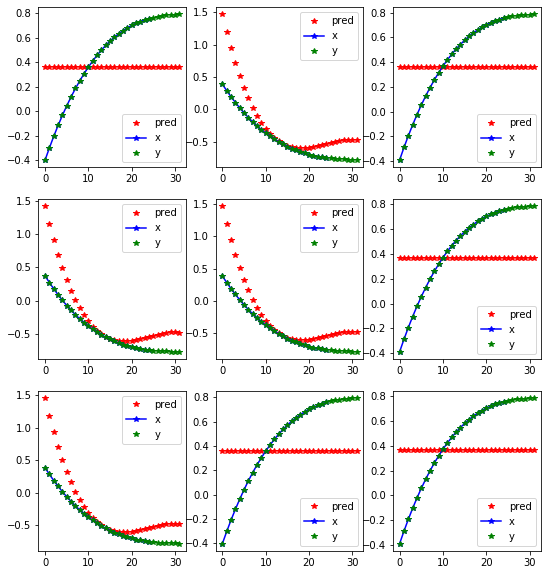

In [ ]:
learn.show_results()

In [ ]:
# hide
mdl = TrendBlock([256], thetas_dim=4, device=device, lookback=100, horizon=10, att=True)
dct = mdl(torch.randn(64,100).to(device))
test_eq(dct['b'].shape, (64,100))
test_eq(dct['f'].shape, (64,10))
test_eq(dct['theta'].shape,(64,4))
test_eq(dct['attention'].shape,(64,4))

In [ ]:
mdl = TrendBlock([256], thetas_dim=4, device=device, lookback=100, horizon=10, att=False)
dct = mdl(torch.randn(64,100).to(device))
test_eq(dct['b'].shape, (64,100))
test_eq(dct['f'].shape, (64,10))
test_eq(dct['theta'].shape,(64,4))
test_eq('attention' not in dct, True)


mdl = TrendBlock([256], thetas_dim=4, device=device, lookback=100, horizon=10, stand_alone=True)
bf = mdl(torch.randn(64,1,100).to(device))
test_eq(bf.shape, (64,1,110))

In [ ]:
# export

# not pritty but still works better
def select_block(o):
    if isinstance(o,int):
        if o == 0:
            return SeasonalityBlock
        elif o == 1:
            return TrendBlock
        elif o == 2:
            return BaisBlock
        else:
            return GenericBlock
    else:
        if o == 'seasonality':
            return SeasonalityBlock
        elif o == 'trend':
            return TrendBlock
        elif o =='bias':
            return BiasBlock
        else:
            return GenericBlock
        
default_thetas={'seasonality':6,'trend':4,'bais':2}

In [ ]:
# export
class NBeatsNet(Module):
    def __init__(
        self,
        device,
        stack_types=('trend', 'seasonality'),
        nb_blocks_per_stack=3,
        horizon=5,
        lookback=10,
        thetas_dim=None,
        share_weights_in_layers=True,
        layers= [1024,512],
        **kwargs,
    ):        
        thetas_dim = ifnone(thetas_dim,[default_thetas[o] for o in L(stack_types)])
        stack_types= L(stack_types)
        store_attr(self,'device,horizon,lookback,layers,nb_blocks_per_stack,share_weights_in_layers,stack_types,thetas_dim,device,kwargs')
        self.stacks = []
        self._str = "| N-Beats\n"
        
        self.bn = BatchNorm(lookback, ndim=2)        
        stacks = OrderedDict()        
        self.base = None
        if self.share_weights_in_layers:
            self.base = make_base(self.lookback, self.layers, True, None)        
        for stack_id in range(len(self.stack_types)):            
            stacks[str(self.stack_types[stack_id]) + str(stack_id)] = self.create_stack(stack_id)
        self.stacks = nn.Sequential(stacks)
        
    def create_stack(self, stack_id):
        stack_type = self.stack_types[stack_id]
        self._str += f"| --  Stack {stack_type.title()} (#{stack_id}) (share_weights_in_stack={self.share_weights_in_layers})\n"
        
        blocks = []
        for thetas_dim in range(3,self.thetas_dim[stack_id]+1):
            block_init = select_block(stack_type)
            block = block_init(
                layers = self.layers,
                thetas_dim = thetas_dim,
                device = self.device,
                lookback = self.lookback,
                horizon = self.horizon,
                base = self.base,  
                **self.kwargs              
                )
            self._str += f"     | -- {block}\n"
            blocks.append(block)
            
        return nn.Sequential(*blocks)

    def forward(self, x):
        self.dct = None
        backcast_res = x.view([-1,x.shape[-1]])
        backcast = torch.zeros(
            size=(backcast_res.size()[0], self.lookback,)
        ) 
        forecast = torch.zeros(
            size=(backcast.size()[0], self.horizon,)
        )  # maybe batch size here.
        
        dct = defaultdict(dict)
        for stack_id, names in enumerate(self.stacks.named_children()):            
            name = names[0]
            for block_id in range(len(self.stacks[stack_id])):
                _dct = self.stacks[stack_id][block_id](backcast_res)
                backcast_res = backcast_res.to(self.device) - _dct['b']      
                
                backcast = backcast.to(self.device) + _dct['b'] 
                forecast = forecast.to(self.device) + _dct['f']
                _dct['_full'] = torch.cat([_dct['b'] , _dct['f']], dim=-1)
                dct[name+'_'+str(block_id)] = _dct
                
        dct['f'] = forecast[:,None,:]
        dct['b'] = backcast[:,None,:]
        self.dct = dct
        return torch.cat([backcast[:,None,:], forecast[:,None,:]], dim=-1)

In [ ]:
show_doc(select_block, name='select_block')

<h4 id="select_block" class="doc_header"><code>select_block</code><a href="__main__.py#L4" class="source_link" style="float:right">[source]</a></h4>

> <code>select_block</code>(**`o`**)



In [ ]:
# hide
mdl = NBeatsNet(torch.device('cpu'), stack_types=('trend','seasonality'), season=lookback+horizon )
_ = mdl(torch.randn(64,1,10))
# print(f.shape,b.shape)
# print([(stack, o['theta']) for stack,o in dct.items()])

In [ ]:
# hide
mdl = NBeatsNet(torch.device('cpu'), stack_types=('trend','seasonality'), share_weights_in_layers=True)
_ = mdl(torch.randn(64,1,10))

In [ ]:
# hide
from fastseq.compare import *
horizon, lookback = 7,25
items = dummy_data_generator(50, 7, nrows=10, norm=True)
data = TSDataLoaders.from_items(items, horizon = horizon, lookback=lookback, step=2, after_batch = NormalizeTS())
                                
mdl = NBeatsNet(device = data.train.device, stack_types=('trend','seasonality'), horizon=horizon, lookback=lookback, season=lookback+horizon)
learn =Learner(data, NBeatsNet(device = data.train.device, stack_types=('trend','seasonality'), horizon=horizon, lookback=lookback),
                            loss_func=F.mse_loss, opt_func= Adam, )             
learn.fit(2,2e-2)

(1, 57)
Train:10; Valid: 60; Test 10


epoch,train_loss,valid_loss,time
0,2.110444,5.078860,00:00
1,2.747366,2.571467,00:00


# Examples

(1, 57)
Train:10; Valid: 60; Test 10


epoch,train_loss,valid_loss,time
0,1.489067,2.089143,00:00
1,1.754921,3.346219,00:00
2,2.006062,1.615925,00:00
3,2.039364,2.552627,00:00
4,1.994792,2.611014,00:00
5,1.965862,2.359165,00:00
6,1.928264,2.756153,00:00
7,1.905979,2.455481,00:00
8,1.848890,2.375421,00:00
9,1.792065,2.350749,00:00


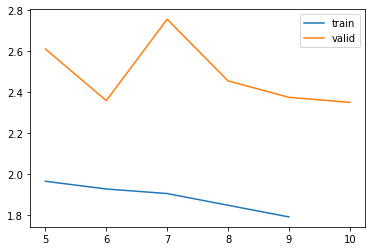

In [ ]:
horizon, lookback = 7,25
items = dummy_data_generator(50, 7, nrows=10, norm=True)
data = TSDataLoaders.from_items(items, horizon = horizon, lookback=lookback, step=2, after_batch = NormalizeTS())
                                
mdl = NBeatsNet(device = data.train.device, stack_types=('trend','seasonality'), horizon=horizon, lookback=lookback, season=lookback+horizon)
learn = Learner(data, mdl, loss_func=F.mse_loss, opt_func= Adam, )                             
                
learn.fit(10, .1)
learn.recorder.plot_loss()                

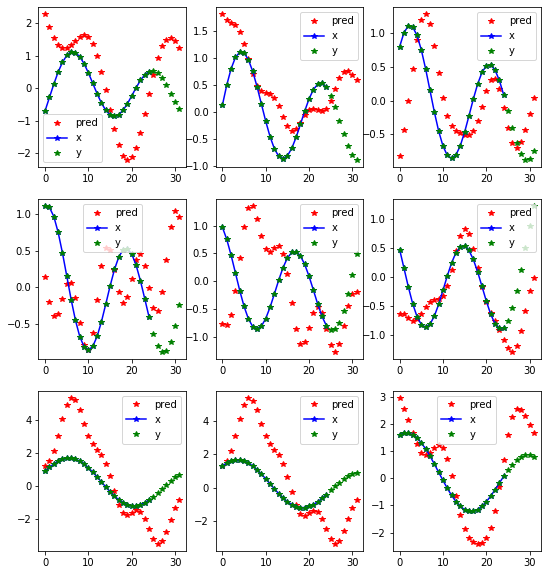

In [ ]:
learn.show_results()

(1, 57)
Train:200; Valid: 200; Test 200


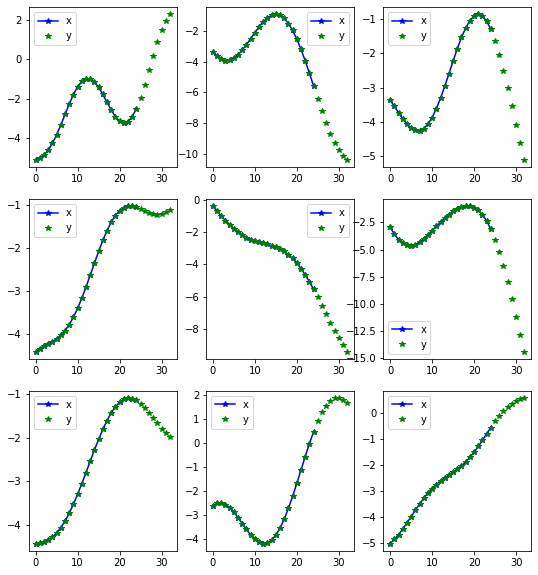

In [ ]:
horizon, lookback = 8,25
items = dummy_data_generator(50, 7, nrows=200)
data = TSDataLoaders.from_items(items, horizon = horizon, lookback=lookback, step=5, after_batch = NormalizeTS(), 
                                valid_pct=.5
                               )          
data.show_batch()

epoch,train_loss,valid_loss,time
0,2.009937,1.578041,00:01
1,1.838040,1.849636,00:01
2,1.773495,1.446254,00:01
3,1.708379,1.364294,00:01
4,1.664079,1.293718,00:01
5,1.627267,1.254092,00:01
6,1.592886,1.210676,00:01
7,1.561307,1.266954,00:01
8,1.536638,1.201898,00:01
9,1.516517,1.209767,00:01


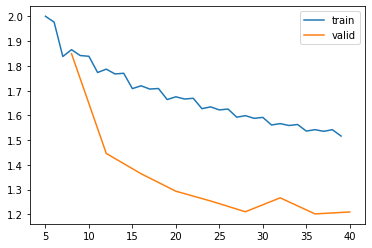

In [ ]:
mdl = NBeatsNet(device = data.train.device, stack_types=('trend','seasonality'), horizon=horizon, lookback=lookback)
learn = Learner(data, mdl, loss_func=F.mse_loss, opt_func= Adam, )                             
                
learn.fit(10, 2e-2)
learn.recorder.plot_loss()

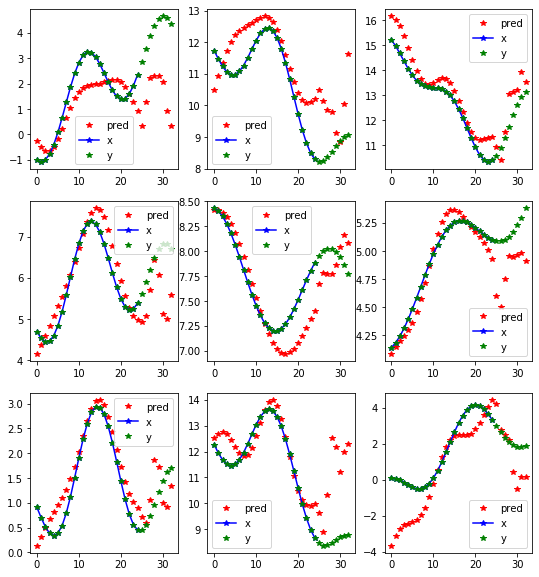

In [ ]:
learn.show_results(0)

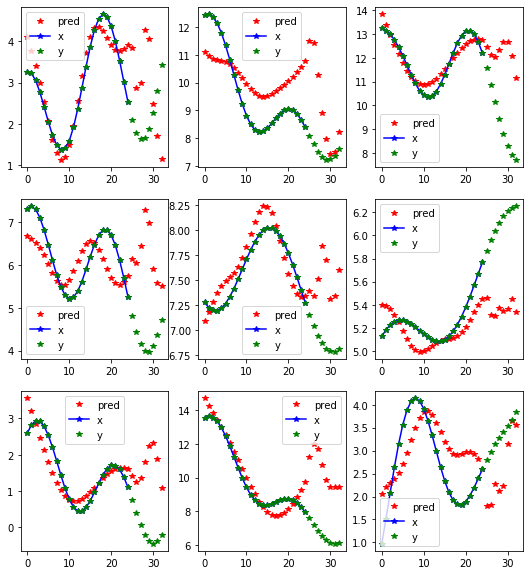

In [ ]:
learn.show_results(1)

In [ ]:
df = pd.read_csv('/home/tako/dev/fastseq/data/airline-passengers.csv')
print(df.head())
items = L([np.array(list(df['Passengers'].values))])
items

     Month  Passengers
0  1949-01         112
1  1949-02         118
2  1949-03         132
3  1949-04         129
4  1949-05         121


(#1) [array([112, 118, 132, 129, 121, 135, 148, 148, 136, 119, 104, 118, 115,
       126, 141, 135, 125, 149, 170, 170, 158, 133, 114, 140, 145, 150,
       178, 163, 172, 178, 199, 199, 184, 162, 146, 166, 171, 180, 193,
       181, 183, 218, 230, 242, 209, 191, 172, 194, 196, 196, 236, 235,
       229, 243, 264, 272, 237, 211, 180, 201, 204, 188, 235, 227, 234,
       264, 302, 293, 259, 229, 203, 229, 242, 233, 267, 269, 270, 315,
       364, 347, 312, 274, 237, 278, 284, 277, 317, 313, 318, 374, 413,
       405, 355, 306, 271, 306, 315, 301, 356, 348, 355, 422, 465, 467,
       404, 347, 305, 336, 340, 318, 362, 348, 363, 435, 491, 505, 404,
       359, 310, 337, 360, 342, 406, 396, 420, 472, 548, 559, 463, 407,
       362, 405, 417, 391, 419, 461, 472, 535, 622, 606, 508, 461, 390,
       432])]

(1, 144)
Train:67; Valid: 19; Test 1


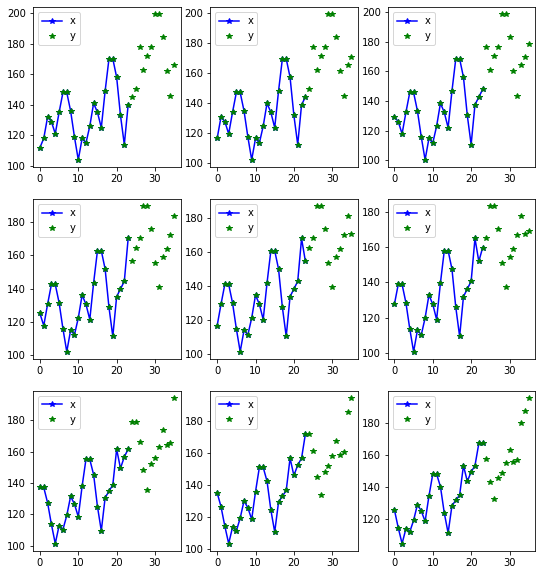

In [ ]:
horizon, lookback = 12,24
data = TSDataLoaders.from_items(items, lookback=lookback, horizon =horizon, step=1, bs=64)
data.show_batch()

epoch,train_loss,valid_loss,time
0,3.769643,2.529434,00:00
1,3.268406,2.027314,00:00
2,2.779646,1.674821,00:00
3,2.512284,1.773315,00:00
4,2.363915,1.718855,00:00
5,2.270988,1.797763,00:00
6,2.210071,1.888839,00:00
7,2.154280,1.653115,00:00
8,2.105669,1.561787,00:00
9,2.071557,1.526706,00:00


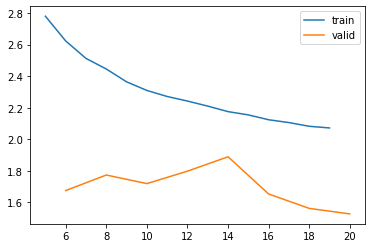

In [ ]:
mdl = NBeatsNet(device = data.train.device, stack_types=('trend','seasonality'), horizon=horizon, lookback=lookback)
learn = Learner(data, mdl, loss_func=F.mse_loss, opt_func= Adam, )                             
                
learn.fit(10, 2e-2)
learn.recorder.plot_loss()

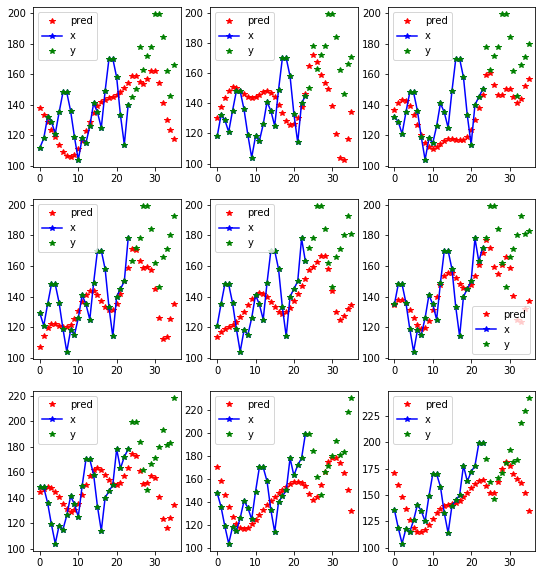

In [ ]:
learn.show_results(0)

# Other Blocks
not tested or tunned

In [ ]:

class LinearD(nn.Linear):   
    """"""
    def forward(self, x, *args, **kwargs):
        return super().forward(x)
        
class GenericBlock(Block):
    def __init__(
        self, layers:L, thetas_dim:int, device, lookback=10, horizon=5, use_bn=True,
        bn_final=False, ps:L=None, share_thetas=True, y_range=[-.05,.05]
    ):
        store_attr(self,"y_range,device,layers,thetas_dim,use_bn,ps,lookback,horizon,bn_final,share_thetas" ) 
        self.scale = torch.ones(self.thetas_dim,device=self.device)
        super().__init__(LinearD(self.thetas_dim, self.horizon),LinearD(self.thetas_dim, self.lookback))        
        self.to(device)
        

In [ ]:
show_doc(LinearD, name='LinearD',title_level=4)

<h4 id="LinearD" class="doc_header"><code>class</code> <code>LinearD</code><a href="" class="source_link" style="float:right">[source]</a></h4>

> <code>LinearD</code>(**`in_features`**, **`out_features`**, **`bias`**=*`True`*) :: `Linear`



In [ ]:
mdl = GenericBlock([256], thetas_dim=4, device=device, lookback=100, horizon=10)
dct = mdl(torch.randn(64,100).to(device))
test_eq(dct['b'].shape, (64,100))
test_eq(dct['f'].shape, (64,10))

In [ ]:
# hide
from nbdev.export import *
notebook2script()

Converted 00_core.ipynb.
Converted 01_data.external.ipynb.
Converted 02_data.load.ipynb.
Converted 03_data.core.ipynb.
Converted 05_nbeats.models.ipynb.
Converted 06_nbeats.callbacks.ipynb.
Converted 07_nbeats.learner.ipynb.
Converted 08_nbeats.interpret.ipynb.
Converted 11_metrics.ipynb.
Converted 12_compare.ipynb.
Converted index.ipynb.
